# Data Science with Playbook Recording Data from NEEMO 20

## Introduction
As NASA prepares to expand manned space exploration missions beyond Earth’s orbit, they plan and carry out a series “analog” missions in various extreme or remote locations here on Earth.  These analogs allow them to evaluate and iterate on tools, techniques, and procedures that will be used in the next generation of manned space flight.

NEEMO, or NASA’s Extreme Environment Mission Operations, is one such analog utilizing the world’s only underwater laboratory off Key Largo, Florida to test tools and techniques for EVAs (space walks).  NEEMO 20, which took place in July/August 2015 focused on building a knowledge base around delayed space communications (crew to mission control).  With that knowledge, they can tune or otherwise optimize tools to better accommodate this facet of missions extending further into space.

One tool under scrutiny during NEEMO 20 was Playbook, a Tablet application developed at NASA which allows astronauts to view plans and procedures, status activities, and send/receive message.  Importantly, Playbook also provides a mechanism to simulate a communications delay between the crew and mission control, which enabled testing of these scenario at NEEMO.


## Project Focus
The goal of this exploration is to examine usage patterns from the playbook tool and look for insights that could inform future design improvements.

### Usage Patterns
First, we'll look at the events that correspond to clicks and taps to see how usage varies during two key scenarios 
- EVAs 
- Simulated Time Delays

### Text Patterns
Second, we'll look for patterns in the body of the messages sent using playbook

## The Data Set
### Log Files
Playbook includes an extension that allows for unobtrusive data recording while in use.  The extension records all user interaction and state changes to log files which map back to activities that the astronauts performed during the NEEMO mission.

The full format of the log files its detailed [here](https://github.com/katylinn/GA-DataScience-Project/blob/master/Recording%20format.docx)

A sample log file can be found here [here](https://github.com/katylinn/GA-DataScience-Project/blob/master/NEEMO20-Crew/sample.log).

Each log file begins by exhaustively describing current state, including the initial time and the full HTML DOM of the display.  Subsequent log entries represent either a user interaction (eg. scroll, tap, key press) or a delta from previous state (change in time or DOM)

There are 920 log files total.  However, there were many challenges in parsing due to idiosyncrasies in the custom recording extension.  I was able to work around the majority of these issues, and include most of the files in the analysis.  However, there was one issue that was unique to a single file, and for expediency, this file was excluded, leaving 919 log files.

### Supplementary Data Files  
There are two pieces of information used to further annotate each event in the data set

1.  Name of the EVA during which the recording was taken (if it took place during an EVA)
2.  Extent of time delay (minutes) which was in effect at the time of the recording.  

I scraped this data from the NEEMO 20 timeline (internal NASA tool).  However, the data itself declared in an extremely large dictionary within a javascript tag, and difficult to “eval” with the hardware at my disposal, so I manually copy/pasted and formatted the subset of information into smaller JSON format files to read into my tidy.py script.  

### Processed Data - tidy.csv
I wrote a preprocessing script, [tidy.py](https://github.com/katylinn/GA-DataScience-Project/blob/master/tidy.py) which reads through each of the log files and creates tidy.csv (too large to include in github repo), a timestamped event log of user interactions that serves as the base for further analysis.  

Each row represents a user interaction, such as a touch, scroll, drag etc.  

The columns are defined as follows:

- recordingId
  * type: string 
  * description: corresponds to the file in which the event was recorded 
  * example: 2015-08-01T110435_231Z_92700
- t
  * type: datetime 
  * description: timestamp of the event (millisecond precision) 
  * example: 2015-07-16 19:41:02.644
- event	
  * type: string
  * description: name of event  
  * examples: scroll, click, key
- other	
  * type: string
  * description: additional event-specific arguments pertaining to the event   
- delay	
  * type: int
  * description: number of minutes communication delay.
  * values: 
    * -1: no comm
    * 0: real time communications
    * 5: 5 minute dela
    * 10: 10 minute delay  
- is_eva	
  * type: bool
  * values: 
    * false: event was not during an EVA
    * true: event was during an EVA
- eva_name	
  * type: string
  * description: name of EVA activity.  
  * example: EVA -Milli-G / Mars Moons
  * note: EVA names are not necessarily unique
- browser	
  * type: string
  * description: HTTP user agent info
  * example: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5)
- clientAddress	
  * type: string
  * description: internal address and port 
  * example: 127.0.0.1:55866
  
The "other" column deserves a special note.  Each type of event records different parameters, so parsing through the “other” column is left to analysis scripts.  This analysis will do so in two cases, tap/click and text.


## Read data and set up Data Frames

Read in all data from tidy.csv

In [2]:
import pandas as pd


all_data = pd.read_csv("tidy.csv", parse_dates=[9])                            #9th column, t, contains the timestamp
all_data["date"] = all_data.t.apply(lambda t: t.date())                        #Parse out date to make plots easier 
events = all_data.drop(["Unnamed: 0", "browser", "clientAddress"], axis=1)     #drop columns we wont use
events.head(7)

,delay,eva_name,event,is_eva,other,recordingId,t,date
0,0,NaN,state,False,"state,view,Timeline",2015-07-16T194059_496Z_4035,2015-07-16 19:41:02.644,2015-07-16
1,0,NaN,state,False,"state,day,1",2015-07-16T194059_496Z_4035,2015-07-16 19:41:02.644,2015-07-16
2,0,NaN,scroll,False,"14,3,0",2015-07-16T194059_496Z_4035,2015-07-16 19:41:19.937,2015-07-16
3,0,NaN,scroll,False,"14,17,0",2015-07-16T194059_496Z_4035,2015-07-16 19:41:19.973,2015-07-16
4,0,NaN,scroll,False,"14,42,0",2015-07-16T194059_496Z_4035,2015-07-16 19:41:19.990,2015-07-16
5,0,NaN,scroll,False,"14,58,0",2015-07-16T194059_496Z_4035,2015-07-16 19:41:20.008,2015-07-16
6,0,NaN,scroll,False,"14,98,0",2015-07-16T194059_496Z_4035,2015-07-16 19:41:20.024,2015-07-16


In [3]:
events.shape

(697020, 8)

### Clicks and Taps 

The first part of the analysis examines usage patterns of clicks and taps, so we create the data frame **clicks** with just those events.

For these events, we can parse the function name out of the *other* column.  The function name is the first argument in the comma separated list of arguments

#### Examples

other | function 
--- | --- 
select,v0,141 | select
toggleDayPicker,v6,13 | toggleDayPicker 

The function indicates the action that occured as a result of the click, which which can serve as a general proxy to determine what was clicked on

In [4]:
clicks = pd.DataFrame(events[(events.event == "tap") | (events.event == "click") ])
clicks["function"] = clicks["other"].apply(lambda s: s.split(",")[0])
clicks.head()

,delay,eva_name,event,is_eva,other,recordingId,t,date,function
11,0,NaN,click,False,"select,v0,141",2015-07-16T194059_496Z_4035,2015-07-16 19:41:23.155,2015-07-16,select
26,0,NaN,click,False,"select,v0,139",2015-07-16T194059_496Z_4035,2015-07-16 19:41:26.158,2015-07-16,select
37,0,NaN,click,False,"toggleDayPicker,v6,13",2015-07-16T194059_496Z_4035,2015-07-16 19:41:27.628,2015-07-16,toggleDayPicker
40,0,NaN,click,False,"updateDay,v1,1377",2015-07-16T194059_496Z_4035,2015-07-16 19:41:28.262,2015-07-16,updateDay
68,0,NaN,click,False,"toggleDayPicker,v6,13",2015-07-16T194059_496Z_4035,2015-07-16 19:41:34.348,2015-07-16,toggleDayPicker


In [5]:
clicks.shape

(10218, 9)

### Messages

The second part of the analysis looks at message content, so we create the data frame **texts** with just text events which indicate that a message (or other text) has been typed into the playbook tool.  

For these events, we can parse the message text out of the *other* column.  The body of the message is the fourth argument in the comma separated list of arguments

#### Examples

other | function 
--- | --- 
v0,895,'FE3','EV crew will start suiting up in... | EV crew will start suiting up in...
v0,166,'FE3','Hating standby diver. EVA crew a... | Hating standby diver. EVA crew a...



In [6]:
texts = pd.DataFrame(events[(events.event == "text")])
texts["text"] = texts.other.apply(lambda o: o.split(",")[3])

texts.head()

,delay,eva_name,event,is_eva,other,recordingId,t,date,text
26951,0,NaN,text,False,"v0,895,'FE3','EV crew will start suiting up in...",2015-07-20T182144_731Z_21488,2015-07-20 18:26:20.676,2015-07-20,'EV crew will start suiting up in 10 min. '
28394,0,NaN,text,False,"v0,166,'FE3','Hating standby diver. EVA crew a...",2015-07-20T183156_281Z_39317,2015-07-20 18:37:44.640,2015-07-20,'Hating standby diver. EVA crew are donning we...
28483,0,NaN,text,False,"v0,166,'FE3','Copy MD1 14:37:44. That\'s hatt...",2015-07-20T183156_281Z_39317,2015-07-20 18:40:25.168,2015-07-20,'Copy MD1 14:37:44. That\'s hatting standby
28549,0,NaN,text,False,"v0,166,'FE3','Both divers have egressed for S/...",2015-07-20T191108_640Z_89252,2015-07-20 19:12:12.077,2015-07-20,'Both divers have egressed for S/L Orientation...
29371,0,NaN,text,False,"v0,2590,'FE3','PET start at 15:13. We\'re 1 ho...",2015-07-20T191814_415Z_88681,2015-07-20 19:21:43.418,2015-07-20,'PET start at 15:13. We\'re 1 hour down on the...


In [7]:
texts.shape

(325, 9)

# Basic Data Exploration

## What are the most popular events? 
This plot shows frequency of different events in the data set.  

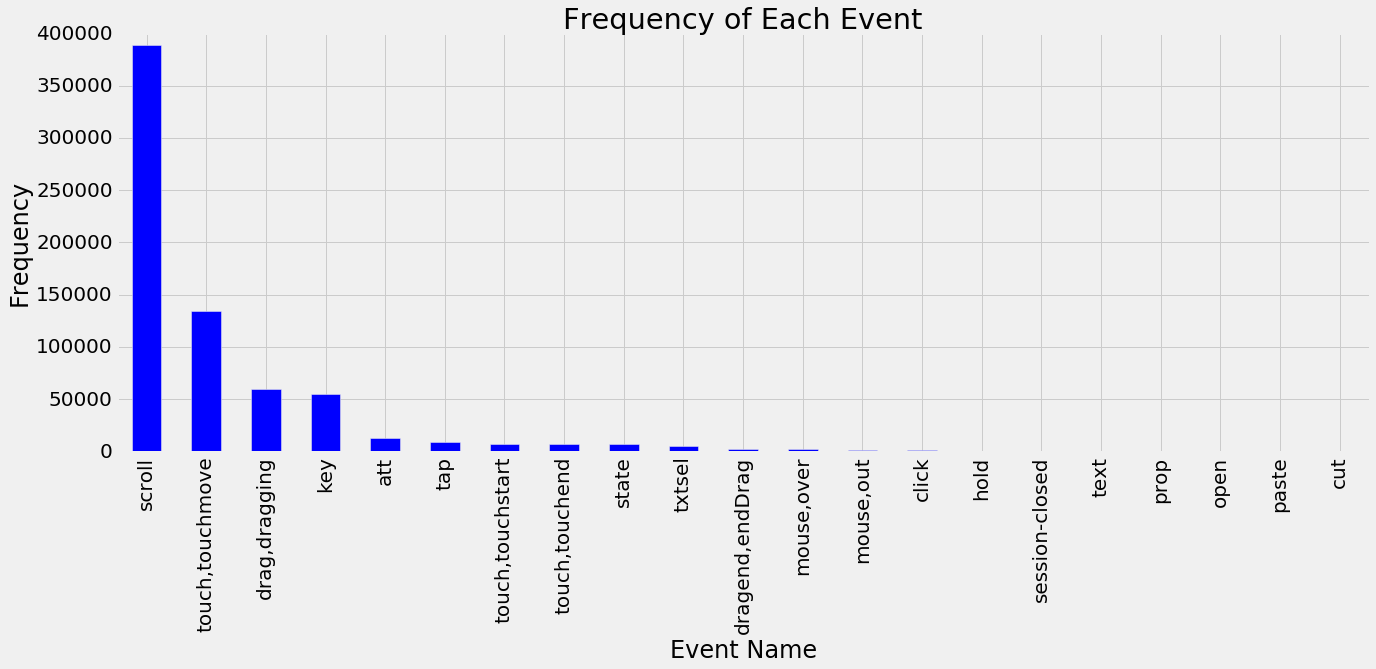

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 7)
plt.rcParams['font.size'] = 20
events.event.value_counts().plot(kind="bar", title="Frequency of Each Event")
plt.xlabel('Event Name')
plt.ylabel('Frequency')

plt.savefig('eventfreqs.png', bbox_inches='tight')

## What gets clicked on the most? 
This plot shows frequency of different function calls in the clicks subset.  The function represents the action that occured as a result of the click.

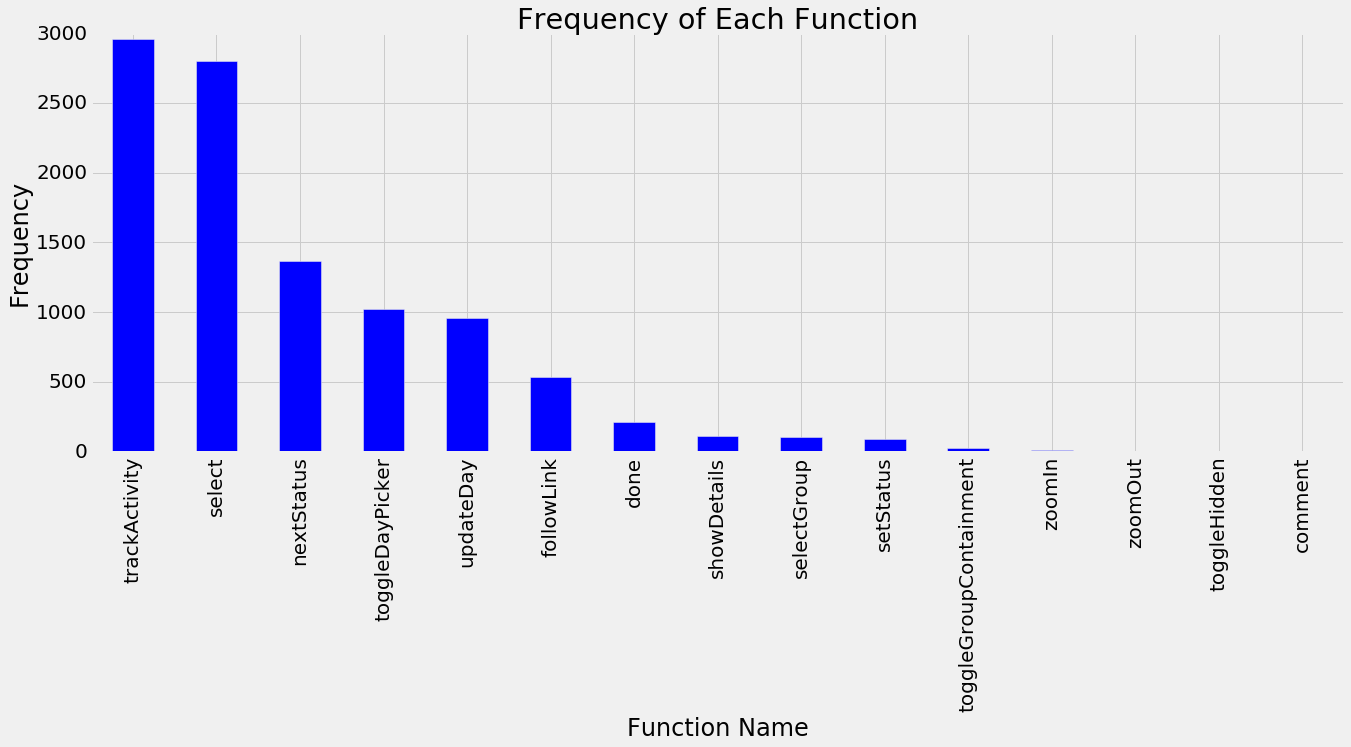

In [9]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 7)
plt.rcParams['font.size'] = 20
clicks.function.value_counts().plot(kind="bar",  title="Frequency of Each Function")
plt.xlabel('Function Name')
plt.ylabel('Frequency')

plt.savefig('clickfreqs.png', bbox_inches='tight')

## What does the data look like over time?
The data set is a timestamped event log.  The following plots shows the volume of the most common events and functions across each day of the mission

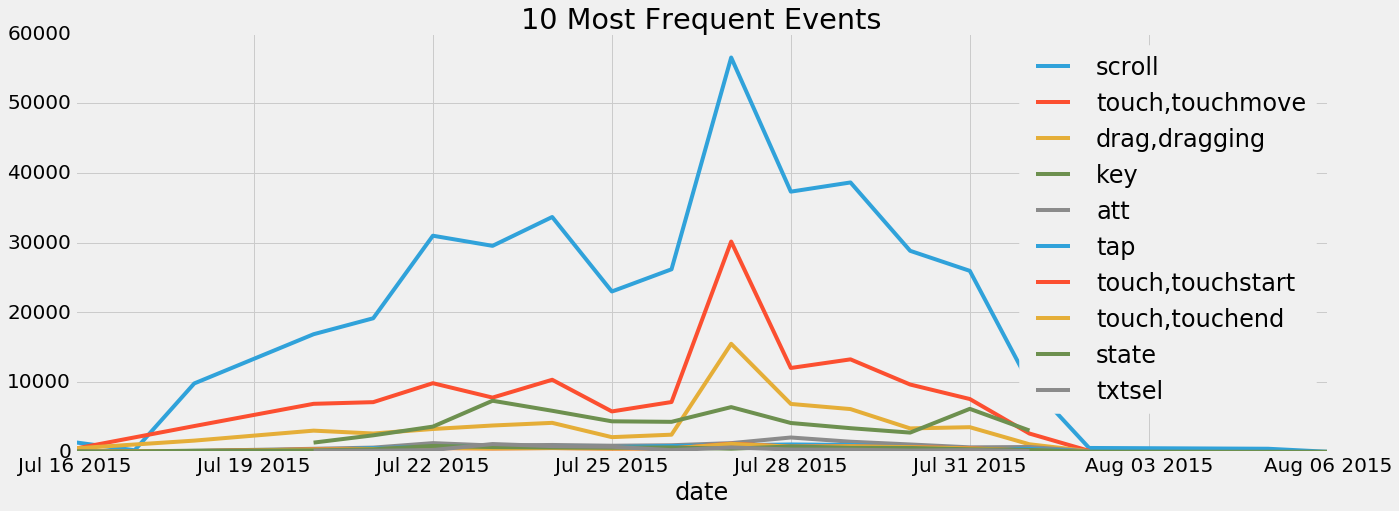

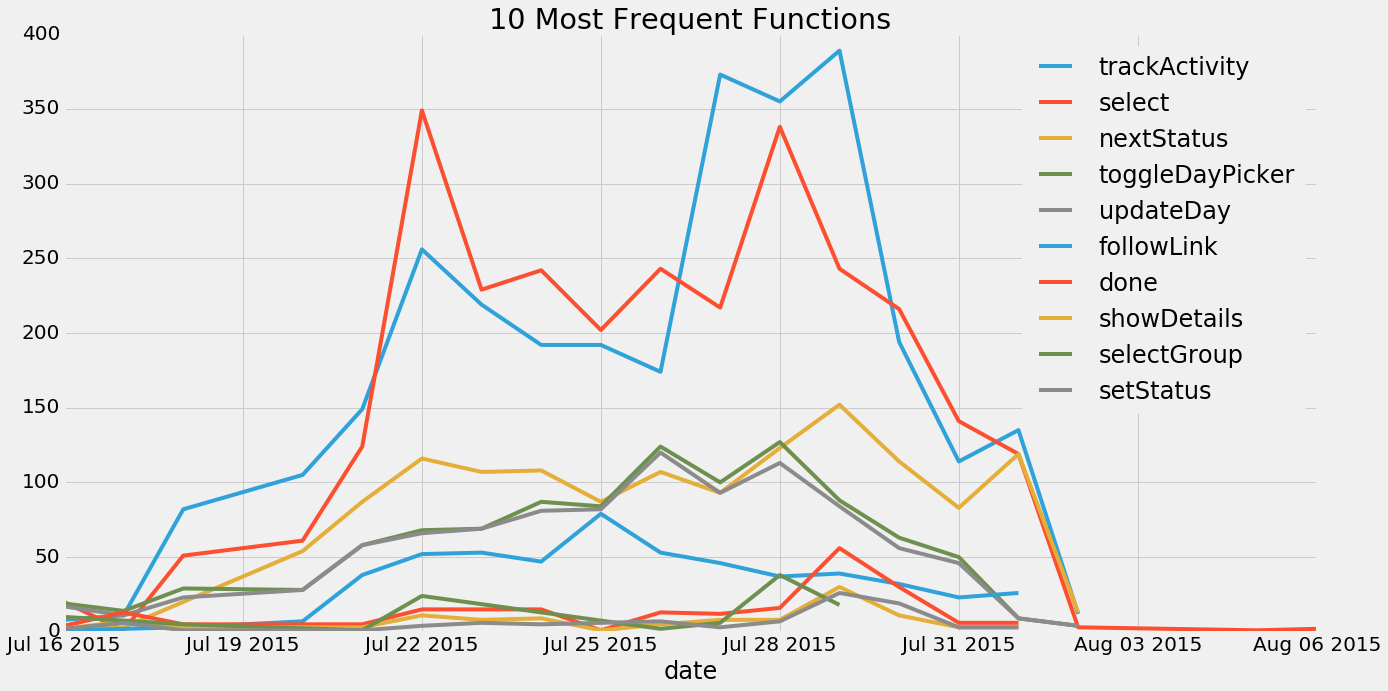

In [10]:
fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20
for feature in events.event.value_counts().head(10).keys():
    events[events.event==feature].groupby("date").size().plot(ax=ax, label=feature, title="10 Most Frequent Events")
ax.legend()
plt.savefig('eventsovertime.png', bbox_inches='tight')


fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20
for feature in clicks.function.value_counts().head(10).keys():
    clicks[clicks.function==feature].groupby("date").size().plot(ax=ax, label=feature,  title="10 Most Frequent Functions")
ax.legend()

plt.savefig('clicksovertime.png', bbox_inches='tight')


# Analyzing differences in usage patterns during EVAs and delayed comunications

 ## Examining Usage Patterns through Click Rates

First, we'll look at the events that correspond to clicks and taps to see how usage varies during two key scenarios 
- EVAs 
- Simulated Time Delays

### Getting the data ready

For proper analysis, the total volume of events does not suffice to accurately describe usage patterns.  If we saw more total clicks to "trackActivity" during real time communications, we wouldn't know if that was a by product of having more recordings during real time communications.  So, we need to look at average per minute click rates to account for uneven coverage across different categories

In [11]:
from collections import defaultdict                    

#recordings will be a list of dictionaries containing summary information for each recording
recordings = []
recording = {}

#use default dict to "count up" occurances of each of the functions in during each recording
functions = defaultdict(int)


for index,row in clicks.iterrows():
    if "id" not in recording:                     #this case catches the very first iteration 
        recording = {                             #and initializes the dictionary
            "id":row["recordingId"],
            "delay": row["delay"],
            "is_eva": row["is_eva"],
            "eva_name": row["eva_name"]
        }
        functions[row["function"]] += 1
    elif recording["id"] == row["recordingId"]:  #this case catches each subsequent event in 
        functions[row["function"]] += 1          #the "current" recording
    else:
        recording["functions"] = functions       #this case catches the case that the recordingId
        recordings.append(recording)             #has changed, so we need to wrap up the current
        recording = {                            #dictionary, append it to the list, and initialize
            "id":row["recordingId"],             #a new one
            "delay": row["delay"],
            "is_eva": row["is_eva"],
            "eva_name": row["eva_name"]
        }
        functions = defaultdict(int)
        functions[row["function"]] += 1
        
recording["functions"] = functions
recordings.append(recording)       
r = pd.DataFrame(recordings)                     #create data frame with the list of recordings



#parse counts out of the dictionary currently contained in r["functions"]
for function_name in clicks.function.value_counts().index:
    r[function_name] = r.functions.apply(lambda fs: fs[function_name])

#to get accurate start and end timestamps for each recording, we have to use the full data set,
#since a "click" might not be the first or last thing to happen in the recording.
#This could be with the loop above, but this is more readable and performance is "good enough"
recordings = []
recording = {}
for index,row in all_data.iterrows():
    if "id" not in recording:                       #this case catches the very first iteration
        recording = {                               #and initializes the dictionary
            "id":row["recordingId"],
            "t_begin": row["t"],
            "t_end": row["t"]
        }
    elif recording["id"] == row["recordingId"]:     #this case catches each subsequent event in 
        recording["t_end"] = row["t"]               #the "current" recording
    else:
        recordings.append(recording)                #this case catches the case that the recordingId
        recording = {                               #has changed, so we need to wrap up the current
            "id":row["recordingId"],                #dictionary, append it to the list, and initialize
            "t_begin": row["t"],                    #a new one
            "t_end": row["t"]
        }
recordings.append(recording)
all_r = pd.DataFrame(recordings)                    #create data frame with the list of recordings

#calculate duration from start and end time
all_r["duration"]=all_r.apply(lambda row: row["t_end"]-row["t_begin"], axis=1)

#join data frames on recordingId
recording_stats = pd.merge(r, all_r, how='left')

#calulate per minute click rates for each function
for function_name in clicks.function.value_counts().index:
    recording_stats[function_name+" per min"] = recording_stats.apply(lambda row: row[function_name]/row["duration"].total_seconds()/60.0, axis=1)

#simple map to determine if there is a time delay in effect
recording_stats["is_delayed"] = r.delay.apply(lambda d: True if d>0 else False)

#take a look at the data
recording_stats.head(3)

,delay,eva_name,functions,id,is_eva,trackActivity,select,nextStatus,toggleDayPicker,updateDay,...,done per min,showDetails per min,selectGroup per min,setStatus per min,toggleGroupContainment per min,zoomIn per min,zoomOut per min,toggleHidden per min,comment per min,is_delayed
0,0,NaN,"{u'showDetails': 0, u'followLink': 0, u'toggle...",2015-07-16T194059_496Z_4035,False,0,9,0,4,4,...,0,0,0.001859,0,0,0,0,0,0,False
1,0,NaN,"{u'showDetails': 0, u'followLink': 0, u'toggle...",2015-07-16T195510_408Z_92903,False,0,0,0,1,1,...,0,0,0.000000,0,0,0,0,0,0,False
2,0,NaN,"{u'showDetails': 0, u'followLink': 0, u'nextSt...",2015-07-16T195807_516Z_89348,False,0,1,0,0,0,...,0,0,0.000000,0,0,0,0,0,0,False


### Visualizing Click Rate Data

The following charts show a how the mean click rate of each function changes depending EVA and time delay 

There are 3 levels of time delay represented in this data:
- 0 (Real time communications)
- 5 min
- 10 min

The groupings are created based on maintaining a reasonable y-axis for the data shown

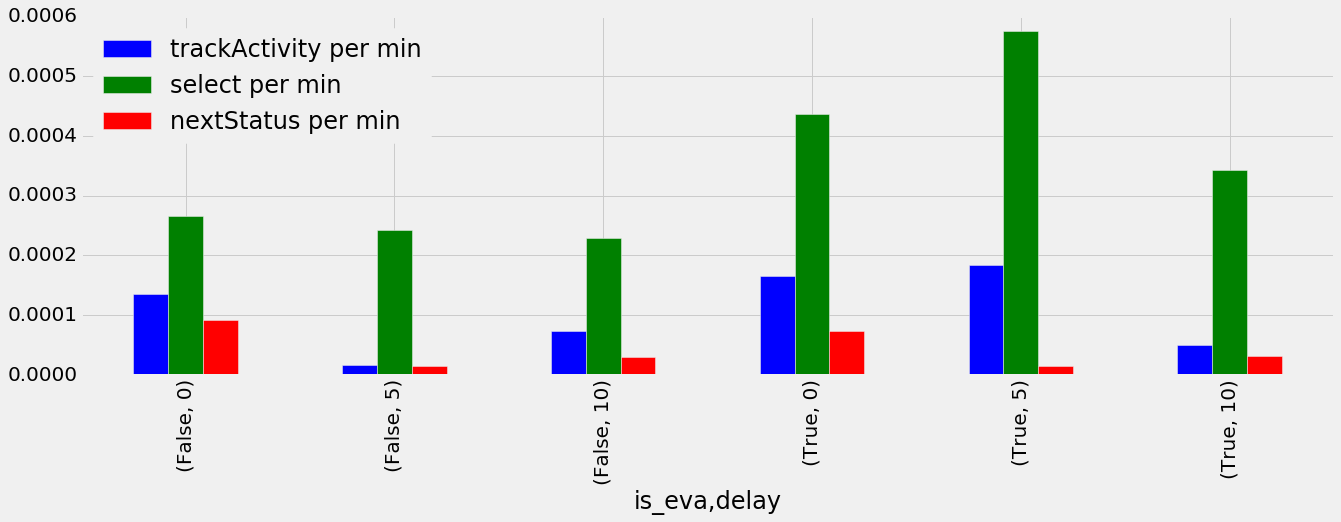

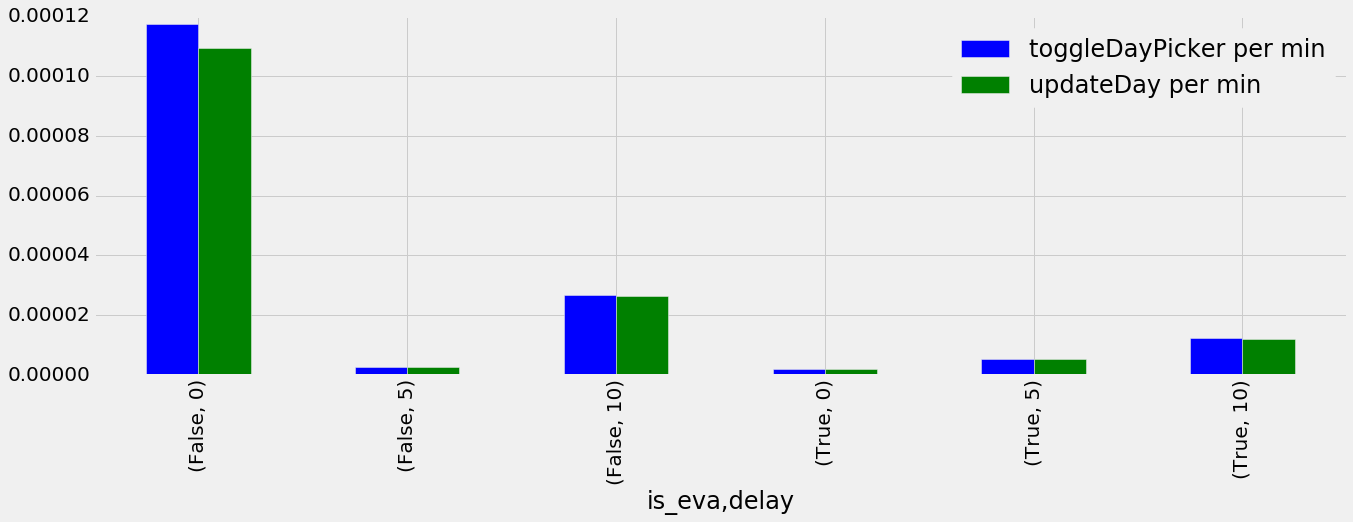

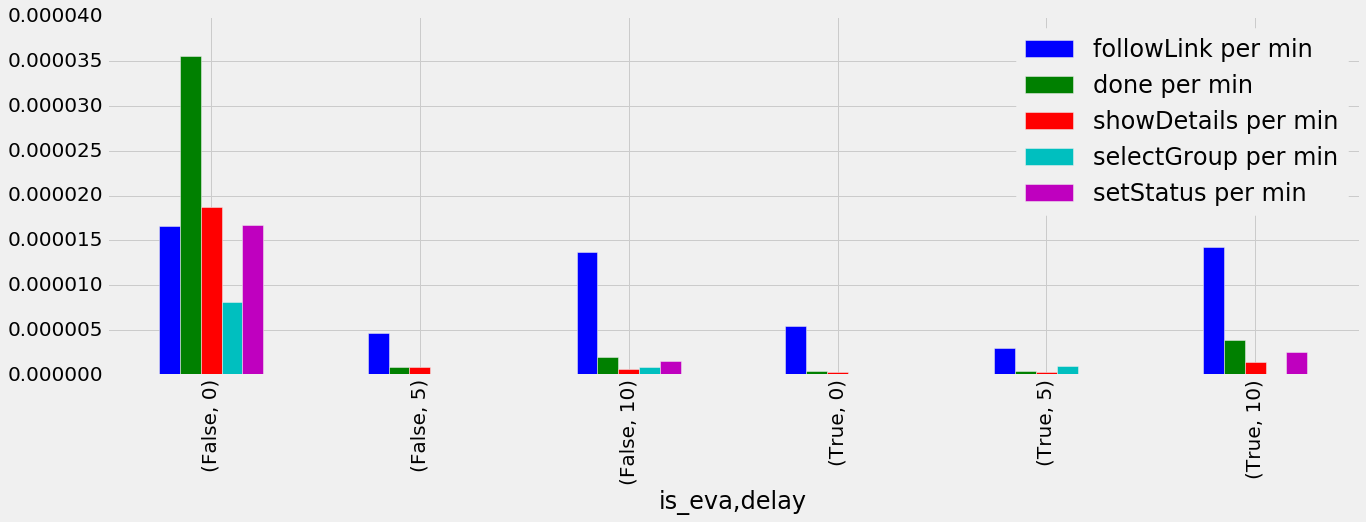

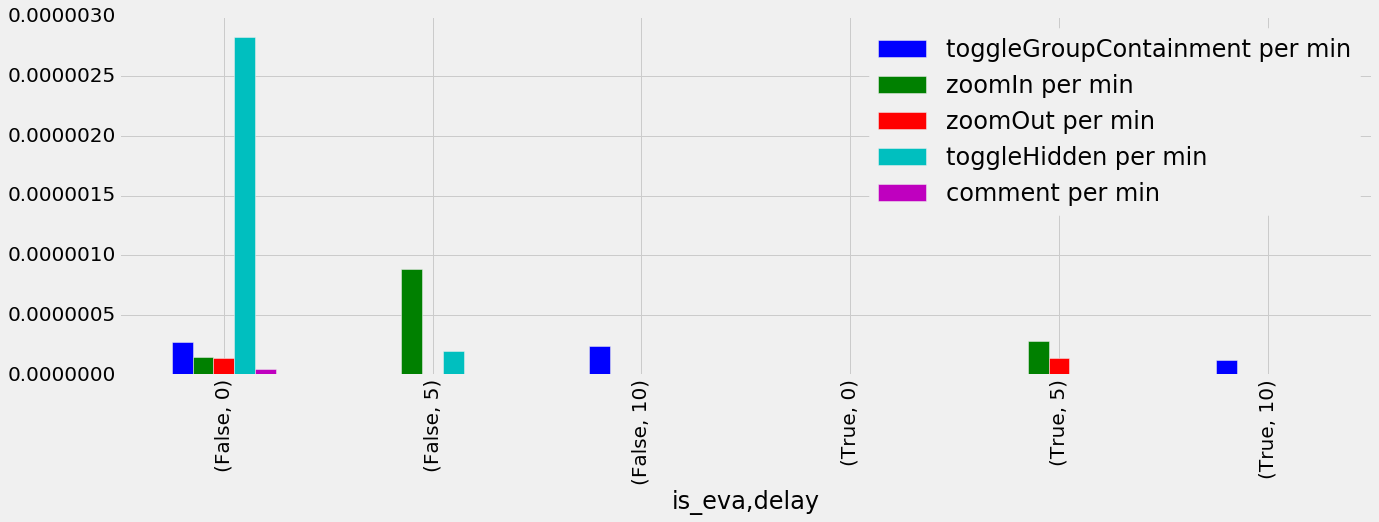

In [12]:
plt.rcParams['figure.figsize'] = (20, 6)
plt.rcParams['font.size'] = 20

plot_cols = ["trackActivity per min", "select per min", "nextStatus per min"]
recording_stats.groupby(["is_eva","delay"])[plot_cols].mean().plot(kind="bar")
plt.savefig('clickrates1.png', bbox_inches='tight')

plot_cols = ["toggleDayPicker per min", "updateDay per min" ]
recording_stats.groupby(["is_eva","delay"])[plot_cols].mean().plot(kind="bar")
plt.savefig('clickrates2.png', bbox_inches='tight')

plot_cols = ['followLink per min','done per min', 'showDetails per min', 'selectGroup per min', 'setStatus per min']
recording_stats.groupby(["is_eva","delay"])[plot_cols].mean().plot(kind="bar")
plt.savefig('clickrates3.png', bbox_inches='tight')

plot_cols = ['toggleGroupContainment per min','zoomIn per min', 'zoomOut per min', 'toggleHidden per min', 'comment per min']
recording_stats.groupby(["is_eva","delay"])[plot_cols].mean().plot(kind="bar")
plt.savefig('clickrates4.png', bbox_inches='tight')

#### Insights:
1.  There seems to be a consistant anomaly in the (False, 0) values, corresponding to real-time communications when there was no EVA occuring.  There is possibly some other factor during that state that could account for higher clickrates on several functions.
2.  The first chart shows a significant increase in "select per min" during EVA
3.  "toggleDayPicker per min" and "updateDay per min" are highly correlated.  Most likely part of a two-click path to change the day being viewed.  Also, aside from the anamoly at (False, 0), click rates for these functions increase as the delay increases, indicating more usage of that feature during delayed comms.

## Examining Patterns in Messages

Second, we'll look for patterns in the body of the messages sent using playbook

In [13]:
texts.head()

,delay,eva_name,event,is_eva,other,recordingId,t,date,text
26951,0,NaN,text,False,"v0,895,'FE3','EV crew will start suiting up in...",2015-07-20T182144_731Z_21488,2015-07-20 18:26:20.676,2015-07-20,'EV crew will start suiting up in 10 min. '
28394,0,NaN,text,False,"v0,166,'FE3','Hating standby diver. EVA crew a...",2015-07-20T183156_281Z_39317,2015-07-20 18:37:44.640,2015-07-20,'Hating standby diver. EVA crew are donning we...
28483,0,NaN,text,False,"v0,166,'FE3','Copy MD1 14:37:44. That\'s hatt...",2015-07-20T183156_281Z_39317,2015-07-20 18:40:25.168,2015-07-20,'Copy MD1 14:37:44. That\'s hatting standby
28549,0,NaN,text,False,"v0,166,'FE3','Both divers have egressed for S/...",2015-07-20T191108_640Z_89252,2015-07-20 19:12:12.077,2015-07-20,'Both divers have egressed for S/L Orientation...
29371,0,NaN,text,False,"v0,2590,'FE3','PET start at 15:13. We\'re 1 ho...",2015-07-20T191814_415Z_88681,2015-07-20 19:21:43.418,2015-07-20,'PET start at 15:13. We\'re 1 hour down on the...


### Visualizing Message Length
The chart below shows how the message length changes as a function of EVA and time delay.  

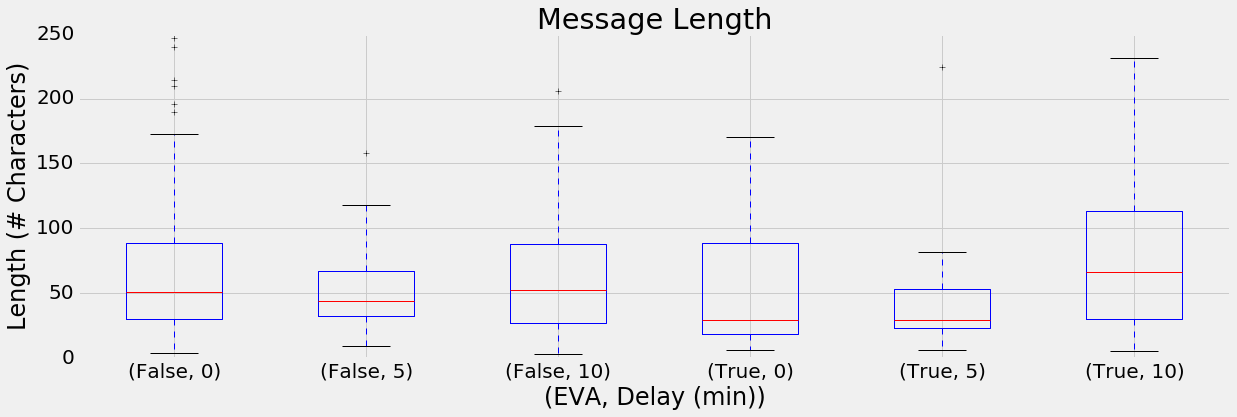

In [14]:
texts["length"] = texts.text.apply(len)
axes = texts.boxplot(column='length', by=['is_eva', "delay"])

plt.ylim((0,250))

fig = axes.get_figure()
fig.suptitle('')
axes.set_title('Message Length')
axes.set_xlabel('(EVA, Delay (min))')
axes.set_ylabel('Length (# Characters)')

plt.savefig('messagelength.png', bbox_inches='tight')

#### Insights
The mean hovers around 50 characters in all cases, but there is also a slight rise as time delay increases.

### Exploring Word Frequencies

The chart below shows frequencies for the most used words across all the messages.

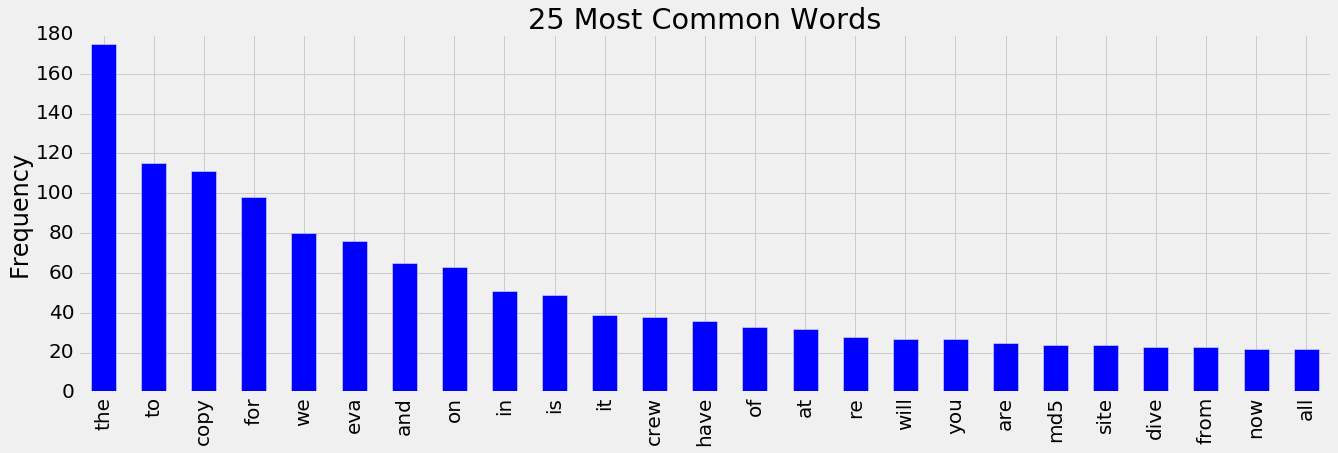

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
counts = pd.DataFrame(vect.fit_transform(texts.text).toarray(), columns=vect.get_feature_names())
counts.sum().sort_values(ascending=False).head(25).plot(kind="bar", title="25 Most Common Words")
plt.ylabel('Frequency')
plt.savefig('commonwords.png', bbox_inches='tight')

The use of the word "copy" seems high relative to its occurance in everyday language and warrants additional scrutiny.

In [16]:
# print messages containing the word "copy" 
texts[(texts["text"].str.contains("Copy"))|(texts["text"].str.contains("copy"))].text.head(25)

28483          'Copy MD1 14:37:44.  That\'s hatting standby
29674     'Copy MD1 15:32:02.  We\'re still getting elec...
32510        'Copy MD1 15:40:12. PC1 has been set up w/Wifi
92474     'Copy MD3 08:09:37. Now R/T channel is running...
118304    'Copy MD3 14:46:44. we\'ll pass the RPE and Di...
137339    'Re EVA:  \n1.  Copy that today is a dynamic m...
137665    'Copy MD4 07:40:50. \nRe NEEMO 20 NAS:  I trie...
144695    'Copy MD4 10:39:00. I\'m so sorry for the conf...
155637    'Copy SBT background notes...I\'ll be sure the...
158009                  'Copy MD4 07:55:49. Re: SBT notices
158440                    'Copy notes on Boulder in zone 3'
158645                                               'Copy'
159200                                    'Copy for Zone 2'
160307                              'Copy on acceptability'
161517                             'Copy on EVA start time'
161636                        'Copy on amendment to Zone 3'
176593                           'Copy M

#### Insight
When we look at messages containing the word copy, we see a very clear and familiar communication pattern.  Crew members use the word "copy" to acknowledge reciept and understanding of a previous message.  In many cases, the author also includes the code for the mission day and a timestamp. 

This insight could definitely lead to a UX improvment whereby the crew member could tap a button to acknowlegde or "copy" a previous message, and have the timestamp recorded automatically.

# Conclusions and Next Steps

Trying to pull "insights" out of a data set is hard.  There were many, many expirements that yeilded no interesting results.  However, there were some interesting results to share:

1.  There is an anamoly causing high click rates across all functions (indicating more intense usage) during non-EVA, real time comm recordings (delay = 0)
2.  "Select" is called far more often during EVA
3.  Day navigation increases as commumications delay increases
4.  Average message length hovers areound 50 characters and increases slightly as communication delay increases
5.  There exists a communication pattern in which the crew members acknowledge previous messages using the word "copy" followed by date and time.  A UX element could provide a shortcut to this functionality.

However, the preprocessing script that parses through the log files and yeilds a tidy data set provides a solid foundation for any further investigations desired.   